In [2]:
#引入需要的模組
import time 
import requests 
import numpy as np 
import pandas as pd 
import mplfinance as mpf 
import matplotlib.pyplot as plt 
from talib import abstract 
from datetime import datetime

In [3]:
##獲取 K 線數據之各式函數 ( 幣安交易所 )
# # DataFrame Setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)
pd.set_option('display.width', 5000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)

# # Global Variables Setting
symbol = 'BTCUSDT'
url = 'https://api.binance.com/'

In [4]:
# # Get Market Data
def GetKline(url, symbol, interval, startTime = None, endTime = None):
    try:
        data = requests.get(url + 'api/v3/klines', params={'symbol': symbol, 'interval': interval, 'startTime': startTime, 'limit': 1000}).json()
    except Exception as e:
        print ('Error! problem is {}'.format(e.args[0]))
    tmp  = []
    pair = []
    for base in data:
        tmp  = []
        for i in range(0,6):
            if i == 0:
                base[i] = datetime.fromtimestamp(base[i]/1000)
            tmp.append(base[i])
        pair.append(tmp)
    df = pd.DataFrame(pair, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df.date = pd.to_datetime(df.date)
    df.set_index("date", inplace=True)
    df = df.astype(float)
    return df

In [5]:
def GetHistoricalKline(url, symbol, interval, startTime):
    # init
    klines = GetKline(url, symbol, interval)
    tmptime = ToMs(klines.iloc[0].name) # 取得最新的 k 线信息 [0] 对应的是 date 日期
    
    # Send request until tmptime > startTime
    while tmptime > startTime:
        tmptime -= PeriodToMs(interval) * 1000 # tmp minus period ms plus 1000 (1000 K)
        if tmptime < startTime:
            tmptime = startTime
        tmpdata = GetKline(url, symbol, interval, tmptime) # 抓取特定时间的 k 线
        klines  = pd.concat([tmpdata, klines])

    return klines.drop_duplicates(keep='first', inplace=False)

In [6]:
# Math Tools
def ToMs(date):
    return int(time.mktime(time.strptime(str(date), "%Y-%m-%d %H:%M:%S")) * 1000) # Binance timestamp format is 13 digits

# 把时间间隔，如: '4h' 转换为 Ms
def PeriodToMs(period):
    Ms = None
    ToSeconds = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    unit = period[-1] # period 如果是 '4h' unit = h

    if unit in ToSeconds:
        try:
            Ms = int(period[:-1]) * ToSeconds[unit] * 1000
        except ValueError:
            pass
    return Ms

In [8]:
#爬取4H K資料
if __name__ == "__main__":
    klines = GetHistoricalKline(url, symbol, '4h', ToMs('2019-05-01 12:00:00'))
    print (klines)

                         open      high       low     close         volume
date                                                                      
2019-05-01 12:00:00   5348.92   5357.00   5337.62   5353.40    1700.049906
2019-05-01 16:00:00   5352.60   5366.90   5326.05   5362.14    2492.910405
2019-05-01 20:00:00   5363.42   5364.00   5333.00   5355.35    2687.890665
2019-05-02 00:00:00   5355.34   5402.00   5342.75   5367.41    4460.837124
2019-05-02 04:00:00   5365.98   5393.54   5355.00   5383.20    1441.683741
2019-05-02 08:00:00   5383.20   5394.00   5373.20   5387.54    1653.188115
2019-05-02 12:00:00   5387.51   5415.00   5370.00   5406.31    2434.210000
2019-05-02 16:00:00   5408.04   5460.00   5405.30   5446.38    4679.065894
2019-05-02 20:00:00   5444.72   5535.60   5418.10   5523.99    6505.034923
2019-05-03 00:00:00   5523.99   5538.00   5472.28   5506.98    4350.239886
2019-05-03 04:00:00   5506.01   5520.00   5484.01   5492.87    3174.049017
2019-05-03 08:00:00   549

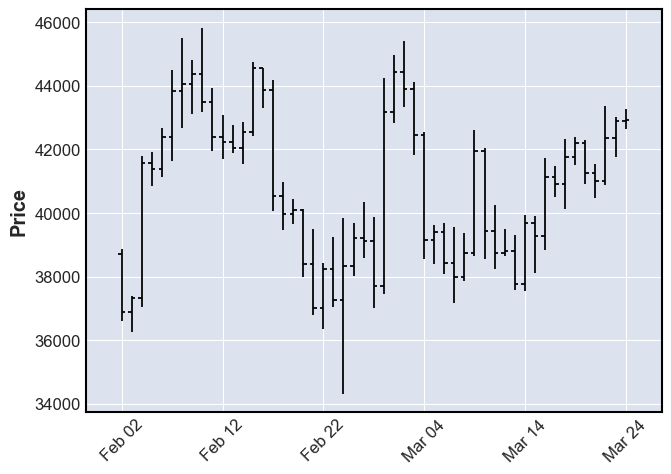

In [18]:
#繪製圖表
if __name__ == "__main__":
    klines = GetKline(url, symbol, '1d', ToMs('2022-02-01 12:00:00'))
    mpf.plot(klines)

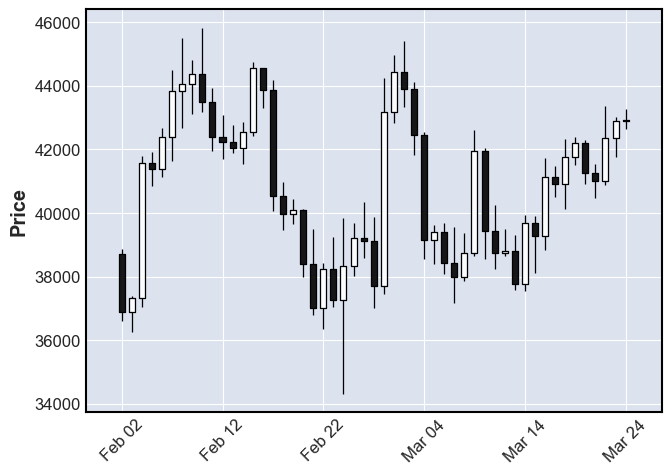

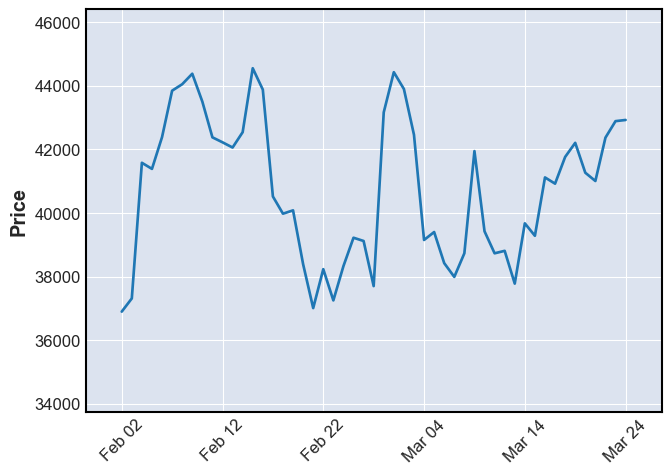

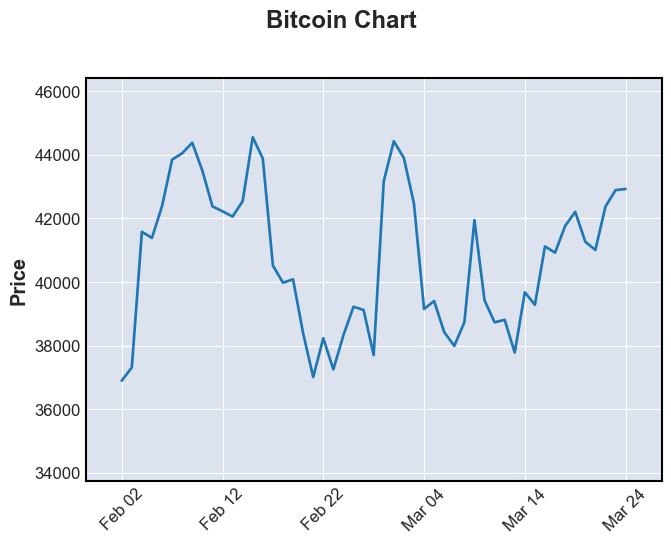

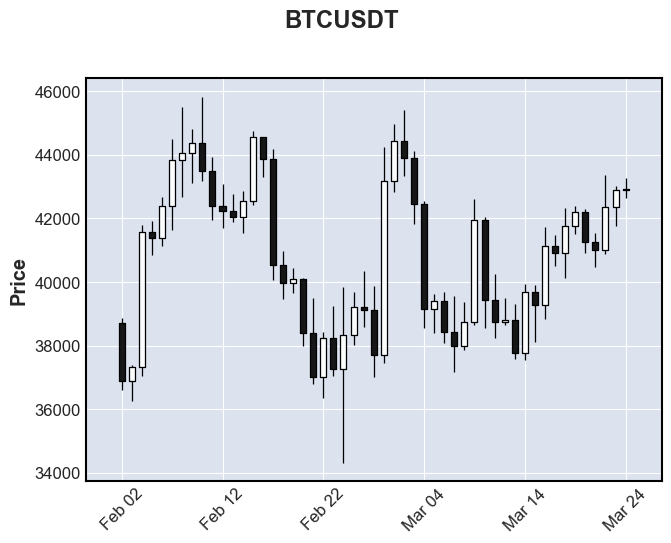

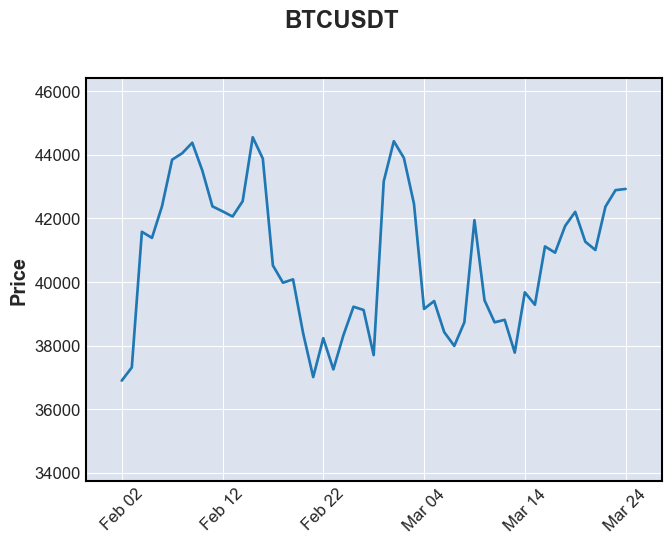

In [19]:
# 蠟燭圖
mpf.plot(klines, type = 'candle') 

# 線圖
mpf.plot(klines, type = 'line') 

#利用 title 參數為圖表加上標題：
mpf.plot(klines, type = 'line', title = 'Bitcoin Chart')

# 用前面的全域變數命名
mpf.plot(klines, type = 'candle', title = symbol) 

#如不想立即顯示圖表的話，可以透過 block 參數控制
mpf.plot(klines, type = 'line', title = symbol, block = False)
plt.show() # 手動打印

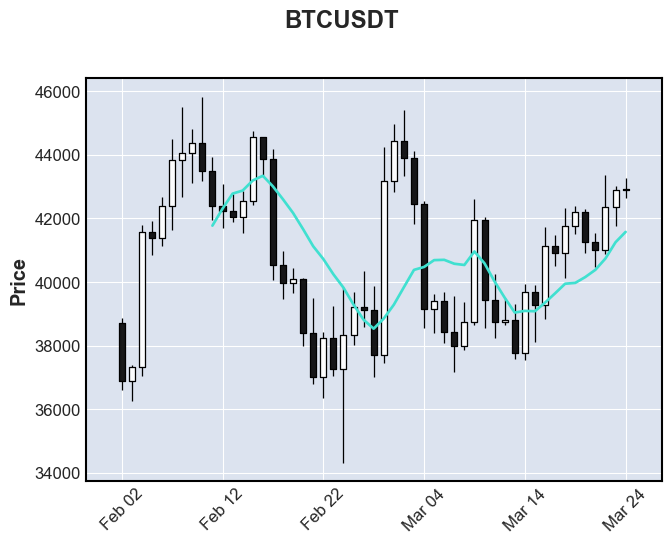

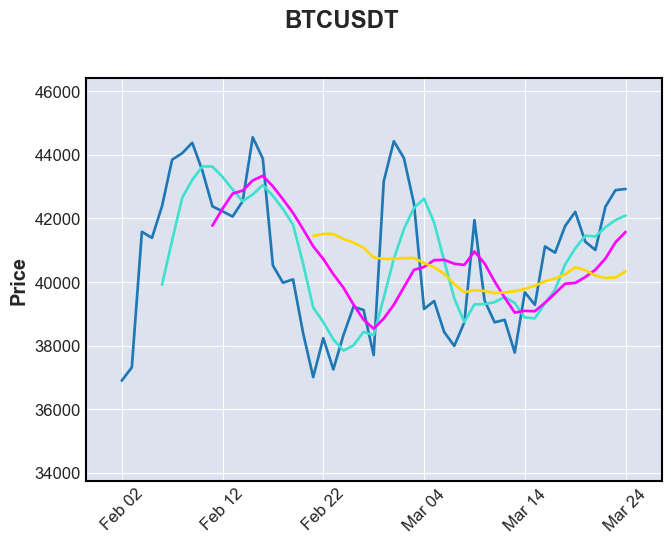

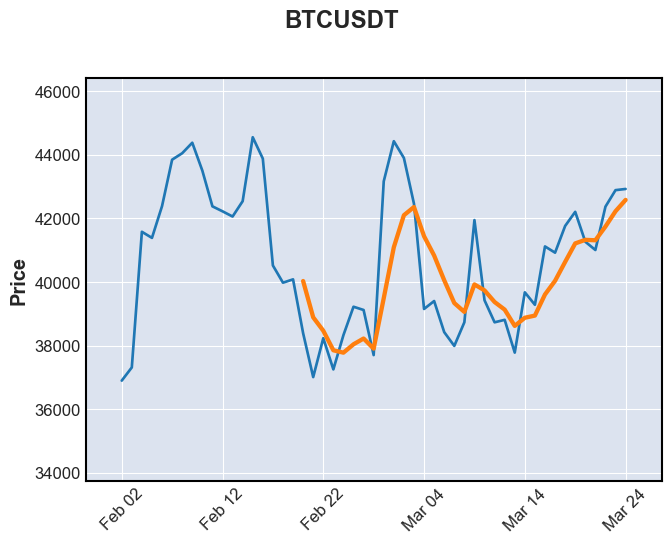

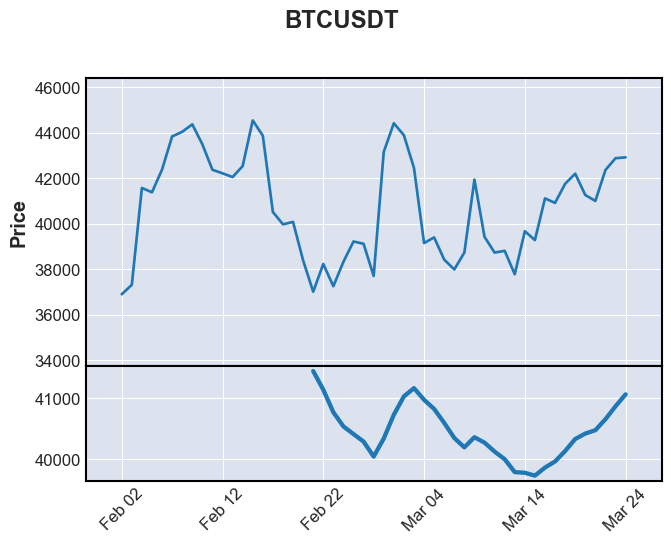

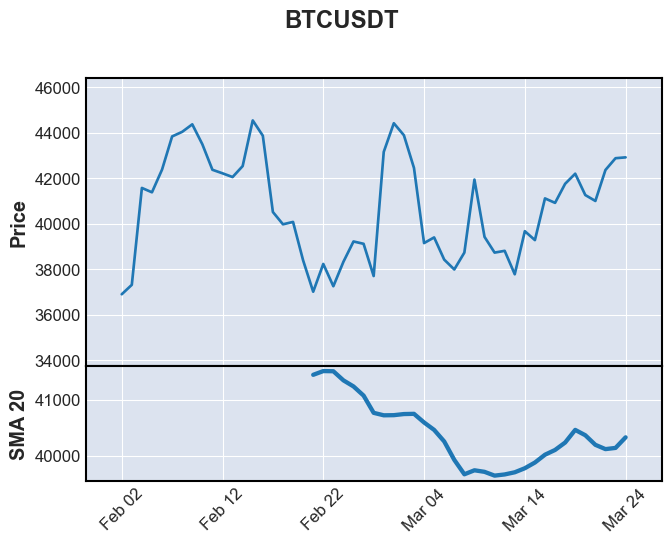

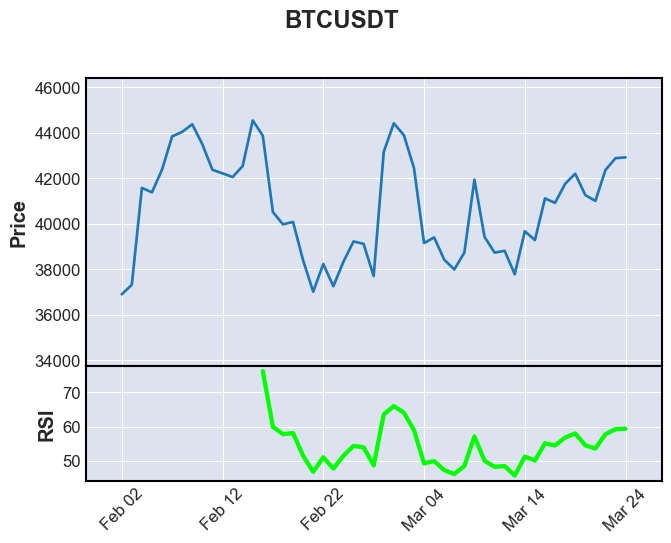

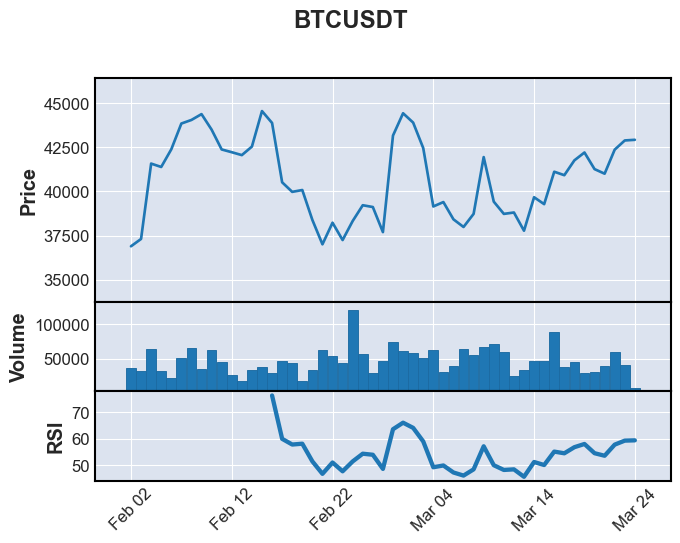

['binance', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'ibd', 'kenan', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo']


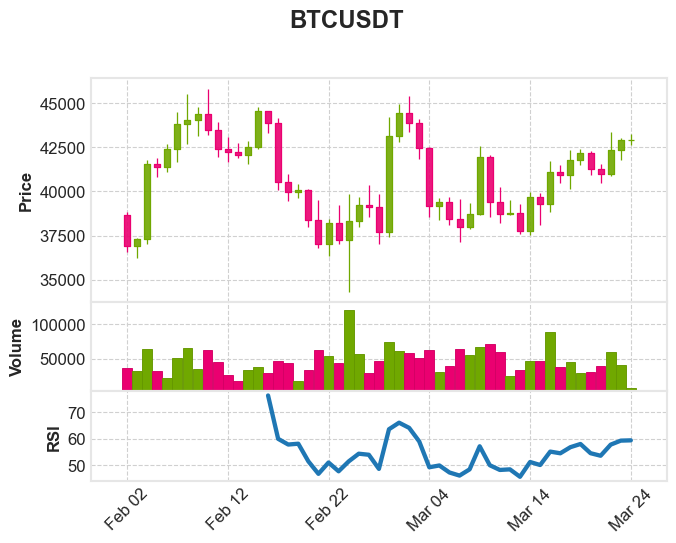

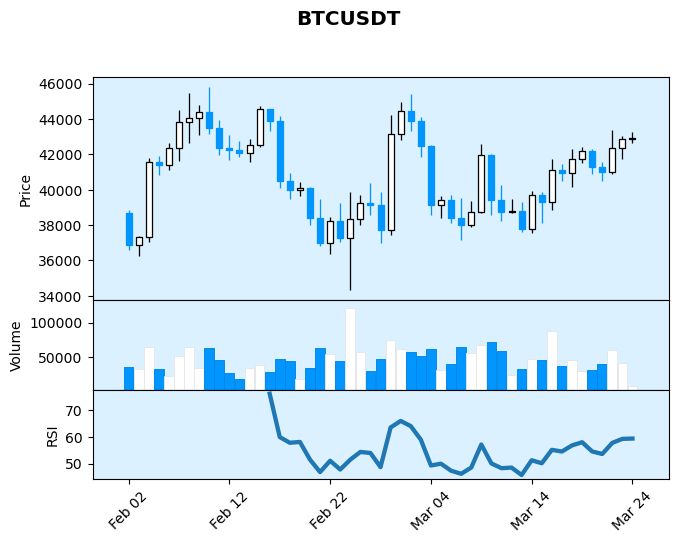

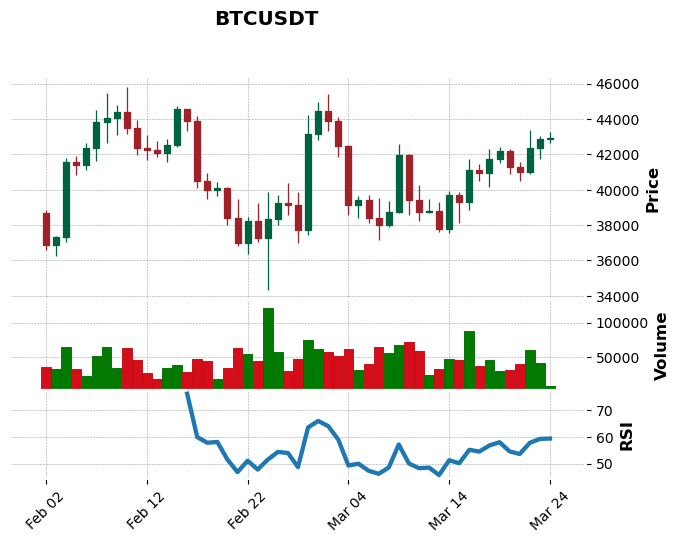

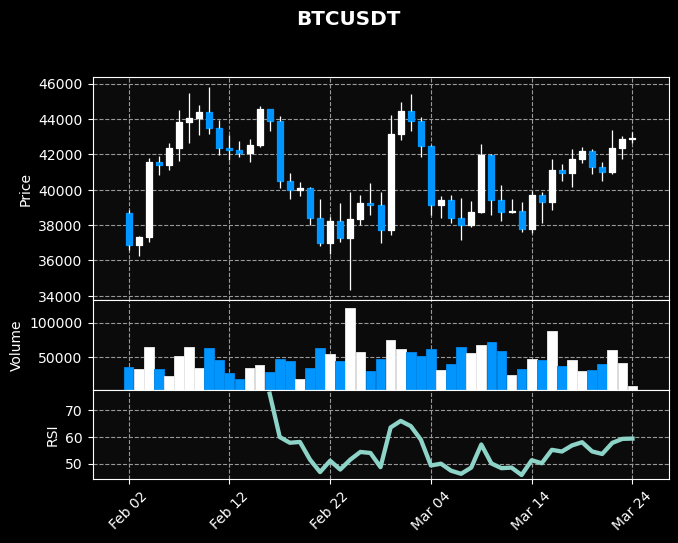

In [21]:
# 單MA直接宣告即可
mpf.plot(klines, type = 'candle', title = symbol, mav = 10)

# 多組均線可以利用元組達成
mpf.plot(klines, type = 'line', title = symbol, mav = (5, 10, 20))

#增加技術指標，以函數方式撰寫，可以變議程指標模組命名為TA_model.py
#先import這個模型，使用某個技術指標時呼叫即可
# # Financial indicators
def DEMA(df, period):
    return abstract.DEMA(df, timeperiod=period)
def EMA(df, period):
    return abstract.EMA(df, timeperiod=period)
def SMA(df, period):
    return abstract.SMA(df, timeperiod=period)

def RSI(df, period):
    return abstract.RSI(df, timeperiod=period)


#DEMA繪製
index  = mpf.make_addplot(DEMA(klines, 10))
mpf.plot(klines, type = 'line', title = symbol, addplot = [index])

#EMA繪製 ( 可以透過 panel 指定繪製區域 )
index  = mpf.make_addplot(EMA(klines, 20), panel = 1)
mpf.plot(klines, type = 'line', title = symbol, addplot = [index])

#SMA繪製 ( 可以透過 ylabel 替指標命名 )
index  = mpf.make_addplot(SMA(klines, 20), panel = 1, ylabel = 'SMA 20')
mpf.plot(klines, type = 'line', title = symbol, addplot = [index])




#RSI繪製 ( 可以透過 color 指定指標繪製時的顏色 )
index  = mpf.make_addplot(RSI(klines, 14), panel = 1, ylabel = 'RSI', color = 'lime')
mpf.plot(klines, type = 'line', title = symbol, addplot = [index])


#增加成交量
index  = mpf.make_addplot(RSI(klines, 14), panel = 2, ylabel = 'RSI')
mpf.plot(klines, type = 'line', title = symbol, addplot = [index], volume = True)

# 可以利用打印輸出所有內建圖表風格
print (mpf.available_styles())
#輸出所有圖表風格
['binance', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo']

# 透過 style 即可調用內建風格，幾個範例：
mpf.plot(klines, type = 'candle', style = 'binance', title = symbol, addplot = [index], volume = True)

mpf.plot(klines, type = 'candle', style = 'blueskies', title = symbol, addplot = [index], volume = True)
mpf.plot(klines, type = 'candle', style = 'charles', title = symbol, addplot = [index], volume = True)
mpf.plot(klines, type = 'candle', style = 'nightclouds', title = symbol, addplot = [index], volume = True)

